In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".13"

In [2]:
import pandas as pd
from brain import BrainModel
from submodels import factories
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from random import shuffle

from lib.score import (
    fate_corr, score_both_size_norm, shrink_and_align_stats, score_stats_norm
)
from lib.preprocess import *
from lib.callback import (
    cell_number_callback, progenitor_number_callback, neuron_number_callback,
    TargetPopulation, TagNumberCallback, TypeNumberCallback,
)
from lib.sde.grn.grn import GRNMain
from lib.sde.mutate import SparseMutator

from lib.ga.utils import weighted_selection_one, normalize_fitness_values
from lib.utils import pick_best, pick_last
from jf.utils.export import Exporter
from jf.autocompute.jf import O, L
from itertools import product
import jf.models.stringmodel as sm
from lib.analyser import show_curve, show_curve_progenitor
from jf.models.stringmodel import read_model
from lib.utils import normalize_time, align_time
from jf.utils.helper import provide_id

In [3]:
REF = O(
    stats=pd.read_csv("reference/ref_tristate2.csv"),  # ref is a mean
)
SM_GEN = read_model("generation")
_MUTATE_FUNC = SparseMutator()

In [4]:
def individual_generator(id_=-1, cb_init=None):
    sol = Solution(GRNMain(7, 5, 1, generate_funcs=cb_init), id_=id_)
    sol.grn.set_mutable()
    sol.grn.genes[0].init = 1
    for gene in sol.grn.genes:
        gene.noise = max(1, gene.noise)
    sol.grn.compile()
    return sol

In [5]:
class Solution:
    def __init__(self, grn, id_=0, parent=-1):
        self.id = id_
        self.grn = grn
        self.parent = parent
        self.fit = -1
        self.stats = None
        
    def copy(self, id_=0):
        return Solution(self.grn.copy(), id_=id_, parent=self.id)
        
    def mutate(self):
        _MUTATE_FUNC(self.grn)

In [6]:
def score_bb_size(bb, ref, *args, **kwargs):
    stats = bb.stats.copy()
    stats, ref_stats = align_time(stats, ref.stats)
    stats_p, ref_p = normalize_time(stats, ref_stats, "progenitor_pop_size", "progenitor_pop_size")
    stats_infra, ref_n = normalize_time(stats, ref_stats, "infra_pop_size", "neuron_pop_size",
                                    "progenitor_pop_size", "progenitor_pop_size")
    stats_supra, _ = normalize_time(stats, ref_stats, "supra_pop_size", "neuron_pop_size",
                                    "progenitor_pop_size", "progenitor_pop_size")
    last_time_stats, last_time_ref = max(stats.time), max(ref_stats.time)
    time_switch = 64.0
    
    ref_p = ref_p.set_index("time")
    ref_n = ref_n.set_index("time")
    stats_p = stats_p.set_index("time")
    stats_infra = stats_infra.set_index("time")
    stats_supra = stats_supra.set_index("time")
    
    prog_early = stats_p.loc[min(last_time_stats, time_switch)]["progenitor_pop_size"]
    neuron_infra_early = stats_infra.loc[min(last_time_stats, time_switch)]["infra_pop_size"]
    neuron_supra_early = stats_supra.loc[min(last_time_stats, time_switch)]["supra_pop_size"]
    
    prog_late = stats_p.loc[last_time_stats]["progenitor_pop_size"]
    neuron_infra_late = stats_infra.loc[last_time_stats]["infra_pop_size"]
    neuron_supra_late = stats_supra.loc[last_time_stats]["supra_pop_size"]
    
    ref_prog_early = ref_p.loc[time_switch]["progenitor_pop_size"]
    ref_neuron_infra_early = ref_n.loc[time_switch]["neuron_pop_size"]
    ref_neuron_supra_early = 0.0
    
    ref_prog_late = ref_p.loc[last_time_ref]["progenitor_pop_size"]
    ref_neuron_infra_late = ref_neuron_infra_early
    ref_neuron_supra_late = ref_n.loc[last_time_ref]["neuron_pop_size"] - ref_neuron_infra_late
    
    delta_late = (abs(prog_late - ref_prog_late) + abs(neuron_infra_late - ref_neuron_infra_late)
                  + abs(neuron_supra_late - ref_neuron_supra_late))
    delta_early = (abs(prog_early - ref_prog_early) + abs(neuron_infra_early - ref_neuron_infra_early)
                  + abs(neuron_supra_early - ref_neuron_supra_early))

    return 1 / max(1, 10000 - 1 * delta_late - 0.5 * delta_early)

In [7]:
def hook_event_handler(cell_program):
    # prob **2 and **4
    q = np.array(cell_program.quantities)
    if random() < (q[0] / 2)**4:  # missing a reset
        cell_program.quantities = cell_program.quantities.at[0].set(0)
        return Action.Divide, GRNCell.Progenitor
    
    if random() < (q[1] / 2)**1.2 * (1 - q[2] / 2)**1.2:
        return Action.DiffNeuron, GRNCell.PostMitoticInfra
    
    if random() < (q[2] / 2)**1.2 * (1 - q[1] / 2)**1.2:
        return Action.DiffNeuron, GRNCell.PostMitoticSupra
    
    return Action.NoOp, None

In [8]:
def get_bb(prun, grn):
    from submodels.grn_auto_v1 import GRNCell
    ccls = factories["grn_auto1"](grn=grn, hooks=dict(event_handler=hook_event_handler))
    callbacks = dict(
        progenitor_pop_size=progenitor_number_callback,
        whole_pop_size=cell_number_callback,
        neuron_pop_size=neuron_number_callback,
        infra_pop_size=TypeNumberCallback(GRNCell.PostMitoticInfra, TargetPopulation.whole),
        supra_pop_size=TypeNumberCallback(GRNCell.PostMitoticSupra, TargetPopulation.whole),
    )
    bb = BrainModel(time_step=0.25, verbose=False, start_population=prun.size, max_pop_size=5e2,
            cell_cls=ccls, end_time=prun.end_time, start_time=50, silent=True, opti=True,
              run_tissue=True, monitor_callbacks=callbacks)
    return bb

In [9]:
def fitness_multistep(prun, grn, steps):
    total_fitness = 0
    stop = False
    previous_time = None
    bb = get_bb(prun, grn)
    # first step
    for step in steps:
        if not bb.run_until(step.end_time):
            stop = True
        
        score_step = step.score_func(bb, prun.ref, max_step=step.end_time, min_step=step.start_time)
        fitness_step = 1.0 / score_step
        fitness_step = min(fitness_step, step.max_fitness)
        total_fitness += fitness_step
        if fitness_step < step.min_fitness or stop:
            return total_fitness, bb.stats
        else:
            previous_time = step.end_time
            step.passed()
        
    return total_fitness, bb.stats

In [10]:
def fitness_step(prun, grn, step):
    bb = get_bb(prun, grn)
    bb.run_until(step.end_time)
    score_step = step.score_func(bb, prun.ref, max_step=step.end_time, min_step=step.start_time)
    fitness = 1.0 / score_step
        
    return fitness, bb.stats

In [11]:
def do_init(prun):
    return individual_generator(provide_id(), prun.cb_init)

def do_fitness(prun, sol):
    fitness, stats = fitness_step(prun, sol.grn, prun.step)
    return fitness, stats

def do_selection(prun, pop_fit, pop):
    if len(pop) < prun.min_pop:
        return individual_generator(provide_id(), prun.cb_init)
    
    pop_fit = normalize_fitness_values(pop_fit)
    
    return weighted_selection_one(pop, pop_fit, lambda x: individual_generator(x, prun.cb_init), new_fitness=10., id_=provide_id())[0]

def do_mutation(prun, sol):
    sol.mutate()
    return sol

In [12]:
class ObjectiveStep(O):
    start_time = 0
    end_time = 0
    max_fitness = 1e9
    min_fitness = 1
    name = ""
    _passed = False
    
    def reset(self):
        self._passed = False
    
    def passed(self):
        if self._passed:
            return
        print(f"Step {self.name} passed !")
        self._passed = True
    
example_step = ObjectiveStep(name="3", start_time=56, end_time=86, score_func=score_bb_size, min_fitness=0.2)

class ParamRun(O):
    pop_size = 50
    batch_size = 50
    n_gen = 50
    current_gen = 0
    end_time = 86
    ref = REF
    min_pop = 50
    max_pop = 50

def get_prun(size=7, exponent=1):
    prun = ParamRun()
    prun.cb_init = dict()
    prun.size = size
    prun.exponent = exponent
    prun.step = example_step
    return prun

In [13]:
def pick_last_exported(exporter):
    generations = list(filter(SM_GEN.match, exporter.list()))
    if len(generations) == 0:
        return None, 0
    
    last = max(generations, key=lambda x: int(SM_GEN.extract(x).get("generation")))
    b_gen = int(SM_GEN.extract(last).get("generation")) + 1
    exporter.print(f"Found generation {b_gen - 1}", "reload")
    pop = exporter.load(last)
    return pop, b_gen

In [14]:
def main(prun):
    prun.history = dict()
    exporter = Exporter(name=prun.name, copy_stdout=True)
    definition = """
    
    """
    exporter.print(definition, slot="definition")
    best = 0
    
    # setup
    pop, batch_gen = pick_last_exported(exporter)
    
    if batch_gen == prun.n_gen:
        print("Already finished")
        return
    
    if pop is None:
        sol = do_init(prun)
        pop = [sol]
        batch_gen = 0
    else:
        sol = pop[-1]
        
    for i in range(batch_gen * prun.batch_size,
                   prun.n_gen * prun.batch_size):
        fit, stats = do_fitness(prun, sol)
        sol.fit, sol.stats = fit, stats
        
        if i % 100 == 0:
            exporter.print(f"Step {i}")
        if fit > best:
            exporter.print(f"++ Best {fit} for generation {i}")
            best = fit
            
        monitor = sol
        prun.history[i] = monitor
        # exporter(monitor, f"generation_g{generation}")
        
        sub_pop = pop[-prun.max_pop:]
        sol = do_selection(prun, [s.fit for s in sub_pop], sub_pop)
            
        sol = do_mutation(prun, sol)
        pop.append(sol)
        
        if (i + 1) % prun.batch_size == 0:
            print("Saving ...")
            batch_gen = (i + 1) // prun.batch_size
            exporter(pop[-prun.batch_size:], SM_GEN.fill(generation=batch_gen))
        
    return best

In [15]:
callback_init = dict(
    init=lambda: np.random.beta(1.5, 3) * 3,
    b=lambda: np.random.beta(1.5, 3) * 5,
    expr=lambda: 1,
    deg=lambda: 0.1,
    noise=lambda: np.random.beta(1.5, 3) * 1,
    asym=lambda: 5,
)

In [ ]:
prun = get_prun()
prun.cb_init = callback_init
prun.name = "test_refacto5"
res = main(prun)

Exporting at output/test_refacto5
[definition] 
    
    
[out] Step 0
[out] ++ Best 9870.748056962342 for generation 0
[out] ++ Best 9871.288873288873 for generation 1
[out] ++ Best 9894.533445319159 for generation 3
[out] ++ Best 9904.93173043173 for generation 15
Saving ...
[out] ++ Best 9907.972546758261 for generation 53
[out] ++ Best 9917.615077972221 for generation 54
[out] ++ Best 9922.778343278342 for generation 57
[out] ++ Best 9923.166424309282 for generation 96
Saving ...
[out] Step 100
[out] ++ Best 9928.564057564057 for generation 107
[out] ++ Best 9936.54397532969 for generation 110
[out] ++ Best 9939.788547359976 for generation 133
Saving ...
[out] ++ Best 9939.870505941934 for generation 186
Saving ...
[out] Step 200
[out] ++ Best 9944.043649400792 for generation 231
Saving ...
[out] ++ Best 9946.217118788547 for generation 252
Saving ...
[out] Step 300
Saving ...
Saving ...
[out] Step 400


In [ ]:
exp = Exporter(name=prun.name)

In [ ]:
sm = read_model("generation")

In [ ]:
res = pick_best(exp.load("generation_g10"))
res = pick_best(exp.load(pick_last(exp)))

In [25]:
res.fit

9940.514767086195

In [ ]:
# for i in range(5):
#     print(fitness_multistep(prun, res.grn, prun.steps))

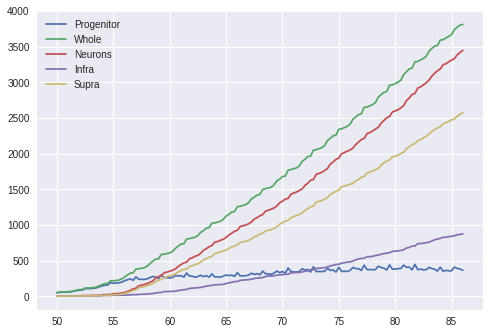

In [26]:
def quick_show(stats):
    plt.plot(stats.time, stats.progenitor_pop_size, label="Progenitor")
    plt.plot(stats.time, stats.whole_pop_size, label="Whole")
    plt.plot(stats.time, stats.neuron_pop_size, label="Neurons")
    plt.plot(stats.time, stats.infra_pop_size, label="Infra")
    plt.plot(stats.time, stats.supra_pop_size, label="Supra")
    plt.legend()
    
quick_show(res.stats)

In [ ]:
show_curve(res.stats, REF.stats)

In [27]:
for g in sorted(filter(sm.match, exp.list()), key=lambda x: int(sm.extract(x)["generation"])):
    gen = exp.load(g)
    res = pick_best(gen)
    print()
    print(f"======= GENERATION {g} {res.fit} =======")
    print(res.grn)


======= GENERATION generation_g1 9904.93173043173 =======
G> G_0: b=0.81; m=7.08; theta=2.83; init=1.00; noise=0.94; expr=1.08; deg=0.10; asym=5.00; tree=()
G> G_1: b=2.47; m=7.14; theta=2.61; init=0.53; noise=1.00; expr=1.00; deg=0.10; asym=5.00; tree=(0.84x2 AND 0.85x0 AND 0.71x0z)
G> G_2: b=1.99; m=8.56; theta=1.46; init=0.49; noise=1.06; expr=1.00; deg=0.11; asym=4.78; tree=(0.17x0 AND -0.62x3 AND 0.49x4)
G> G_3: b=2.00; m=4.42; theta=7.80; init=1.73; noise=0.84; expr=1.01; deg=0.10; asym=5.00; tree=(0.61x0 AND -0.92x2 AND -0.94x4 AND -0.07x3)
G> G_4: b=0.07; m=6.83; theta=5.26; init=1.19; noise=1.00; expr=1.00; deg=0.09; asym=5.00; tree=(-0.87x4 AND -0.36x3 AND 0.36x0z)
G> G_5: b=0.57; m=5.04; theta=1.21; init=0.77; noise=1.00; expr=1.00; deg=0.10; asym=4.51; tree=(0.05x3)
G> G_6: b=1.69; m=4.12; theta=4.75; init=0.22; noise=1.00; expr=1.02; deg=0.10; asym=5.00; tree=()
R> tree=(1.00x3 OR -0.71x2 OR 0.85x1)
R> tree=()
R> tree=(-0.85x4 OR 0.59x0 OR 0.93x1)
R> tree=()
R> tree=(0.15